# Investment Calculator - Solar Plant

<p class="meta" style="color:#aaa; float:right">Stemwede, 2022-08-13</p>
<br style="clear:both"/>

This blog post contains a re-usable "calculator notebook" that can be used to model financial investment.
The example use-case we demonstrate in this note, is a Solar Plant with the following parameters:

- 20,000 EUR are the costs of the system (INV_AMOUNT)
- 1,520 EUR are the annual returns (INV_ANNUAL_RETURN)
- 20 years expected lifetime the system (INV_LIFETIME)

The question we seek to answer is (a) Is this worth buying? and (2) How much credit should I take?

## Optimize Credit Leverage

When leveraging investments with a credit, we have two variables at hand, that we can control:

- The credit amount, e.g. 10,000 EUR (CREDIT_AMOUNT) 
- The credit duration, e.g. 10 years (CREDIT_YEARS)

We assume here a fixed interest rate of 6% (CREDIT_INTEREST) indepdendent of the two variables.
We consider a credit as optimal, if it maximizes the return on the equity we needed to invest ourselves.

The model optimizes the credit by searching over a given range or credit amounts and credit durations.

## Opportunity Costs

Instead of buying a solar plant, we could have invested our equity into the stock market. Variables to cosider here are:

- The long-term stock interest rate 5% (EQ_INTEREST)
- The long-term inflation 2% (EQ_INFLATION)

If the value of the investment is larger than the opportunity costs, this is a signal that the investment could be worth making.

## Usage

- The source notbooks for these calculators are available on [GitHub](https://github.com/HeinrichHartmann/pub/blob/master/InvestementCalculator.ipynb).
- Launch Interactive Version on Binder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/HeinrichHartmann/pub/master?labpath=InvestementCalculator.ipynb)

## Analysis

In [13]:
# Implementation ...
# @CX-TOGGLE
# Run once, then comment out
# !pip install ipytest numpy pandas numpy_financial

from dataclasses import dataclass

import numpy as np
import numpy_financial as npf
import pandas as pd
from scipy.optimize import minimize, minimize_scalar
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import display, HTML
plt.rcParams["figure.figsize"] = (20,5)
matplotlib.style.use('seaborn-v0_8-whitegrid')

import ipytest
import pytest
ipytest.autoconfig()

def P_EUR(num):
    print(f"{num:,.0f} EUR")
    
def P(num, unit):
    print(f"{num:,.1f} {unit}")
    
def p(text):
    print(text, end='')
    
def H(s):
    display(HTML(s))

class CashFlow(pd.Series):
   
    @classmethod
    def from_constant(cls, years, value):
        return cls(np.zeros(years + 1) + value)

    @classmethod
    def from_investment(cls, N, PV, PMT):
        cf = np.zeros(N + 1)
        cf[0] = -PV
        cf[1:] += PMT
        return cls(cf, name="Cash Flow")
    
    def pad(self, years):
        return CashFlow(self.copy().reindex(range(years + 1), fill_value = 0))

    def shift(self, n):
        return CashFlow(np.concatenate([[0]*n, self]))
    
    def plot(self, **kwargs):
        if not "kind" in kwargs:
            kwargs["kind"] = "bar"
        ax = super().plot(**kwargs)
        plt.title("Cash Flow Plot")
        plt.ylabel("Cash Flow/EUR")
        plt.xlabel("Year")
        plt.axhline(y=0, color='k', linewidth=0.5)
        return ax

    def discount(self, interest_rate):
        discount_factor = 1 / (1 + interest_rate) ** np.arange(len(self))
        return CashFlow( self * discount_factor )

    def present_value(self, interest_rate):
        return npf.npv(interest_rate, self)
    
    def neg(self):
        o = self.copy()
        o[ o > 0 ] = 0
        return CashFlow(o)
    
    def pos(self):
        o = self.copy()
        o[ o < 0 ] = 0
        return CashFlow(o)
    
    def equity_need(self):
        return max(0, -self.cumsum().min())
    
    def roi(self):
        "Return on investment. Assumes that cash flow is already discounted."
        # inv = -self.neg().sum() # sum all payments
        inv = self.equity_need()
        ret = self.pos().sum()  # value we gained until end
        return ret/inv

    def aroi(self):
        "Annualized return on investment. Assumes that cash flow is already discounted"
        return self.roi() ** (1./(len(self)-1)) - 1
    
    def __add__(self, other):
        l = max(len(self), len(other)) - 1
        return CashFlow( np.array(self.pad(l)) + np.array(other.pad(l)) )

# ValueSeries Implementation ...
class ValueSeries(pd.Series):
    "Represents the value of an asset over time."
    
    @classmethod
    def from_deposit(cls, years, amount):
        return cls(np.zeros(years + 1) + amount, name="Value Series")
    
    @classmethod
    def from_cash_flow(cls, cf : CashFlow):
        return cls(np.cumsum(cf), name="Value Series")
    
    def shift(self, n):
        return ValueSeries(np.concatenate([[self.iloc[0]]*n, self]))
    
    def pad(self, years):
        return ValueSeries(self.copy().reindex(range(years+1), fill_value = self.iloc[-1]))

    def with_interest(self, interest_rate):
        out = ValueSeries(self.copy())
        for i in range(1, len(out)):
            out[i:] += out[i-1] * interest_rate
        return out
        
    def discount(self, interest_rate):
        discount_factor = 1 / (1 + interest_rate) ** np.arange(len(self))
        return ValueSeries(self * discount_factor)
        
    def cash_flow(self, start_value = 0):
        cf = self.diff().fillna(0).copy()
        cf[0] = self[0] - start_value
        return CashFlow(cf)
    
    def roi(self):
        "Return on investment."
        inv = self.iloc[0] # investment = start value
        ret = self.iloc[-1] # return = end value
        return (ret)/inv

    def aroi(self):
        "Annualized return on investment. Assumes that cash flow is already discounted"
        return self.roi() ** (1./(len(self)-1)) - 1

    def total(self):
        return self.iloc[-1]
    
    def plot(self, **kwargs):
        if not "kind" in kwargs:
            kwargs["kind"] = "bar"
        ax = super().plot(**kwargs)
        plt.ylabel("EUR")
        plt.xlabel("Year")
        plt.axhline(y=0, color='k', linewidth=0.5)
        plt.ylabel("Accumulated Value")
        plt.title("Accumulated Value Plot")
        return ax
        
    def __add__(self, other):
        l = max(len(self), len(other)) - 1
        return ValueSeries( np.array(self.pad(l)) + np.array(other.pad(l)) )
    
    def __radd__(self, other):
        l = max(len(self), len(other)) - 1
        return ValueSeries( np.array(self.pad(l)) + np.array(other.pad(l)) )
    
# Credit Model ...

@dataclass
class Credit:
    amount : float
    years  : int
    interest : float

    def rate(self):
        return - npf.pmt(self.interest, self.years, self.amount)

    def cash_flow(self):
        if self.years == 0:
            return CashFlow(np.zeros(1))
        cf = np.zeros(self.years + 1)
        cf[0] = self.amount
        cf[1:] = - self.rate()
        return CashFlow(cf)
    
    def costs(self):
        return self.rate() * self.years

class DObject:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

def optimize_xy(f_objective, x_range : np.array , y_range: np.array):
    """
    Find optimal values on x-y grid:
    f_objective  : objective function that we want to maximize
    x_range      : range of x-values to search
    y_range      : range of y-values to serach  
    """

    # Optimization
    VAL = np.array([[ _obj(x, y) for y in y_range ] for x in x_range])
    xi_best, yi_best = np.unravel_index(VAL.argmax(), VAL.shape)
    
    # Helper
    x_best = x_range[xi_best]
    y_best = y_range[yi_best]
    o_best = VAL[xi_best, yi_best]
    x_len = len(x_range)
    y_len = len(y_range)
    x_lim = (x_range[0], x_range[-1])
    y_lim = (y_range[0], y_range[-1])
    
    # Return locals wrapped in as object
    return DObject(**{ k:v for k,v in locals().items() if not k.startswith("_") })
    

In [3]:
%%ipytest
# Tests...
# @CX-REMOVE
# 

def test_from_constant():
    cf = CashFlow.from_constant(3, 1000)
    assert (cf == [1000, 1000, 1000, 1000]).all()

def test_pad():
    cf = CashFlow([1000, 1000, 1000])
    cf_padded = cf.pad(4)
    assert (cf_padded == [1000, 1000, 1000, 0, 0]).all()

def test_shift():
    cf = CashFlow([1000, 1000, 1000])
    cf_shifted = cf.shift(2)
    assert (cf_shifted == [0, 0, 1000, 1000, 1000]).all()

def test_discount():
    cf = CashFlow([1000, 1000, 1000])
    discounted = cf.discount(0.1)
    assert discounted[0] == pytest.approx(1000, 0.01)
    assert discounted[1] == pytest.approx(909.09, 0.01)
    assert discounted[2] == pytest.approx(826.45, 0.01)

def test_neg():
    cf = CashFlow([-1000, -500, -500])
    cf_neg = cf.neg()
    assert (cf_neg == [-1000, -500, -500]).all()

def test_pos():
    cf = CashFlow([-1000, 500, 500])
    cf_pos = cf.pos()
    assert (cf_pos == [0, 500, 500]).all()

def test_equity_need():
    cf = CashFlow([-1000, -500, -500])
    eq_need = cf.equity_need()
    assert eq_need == 2000

def test_CashFlow():
    CF = CashFlow.from_investment(30, 20000, 1250) 
    assert CF.discount(0.05).sum() == CF.present_value(0.05)
    assert CF.discount(0).sum() == CF.sum()
    assert CF.present_value(0) == CF.sum()
    
def test_roi():
    cf = CashFlow([-100, 100, 100, 100])
    assert np.isclose(cf.roi(), 3, atol=1e-5)

def test_aroi():
    cf = CashFlow([-100, 100, 100, 100])
    assert np.isclose(cf.aroi(), 3 ** (1/3) - 1, atol=1e-5)

def test_reverse():
    # Discounting reverses the effect
    AV = ValueSeries.from_deposit(30, 20000).with_interest(0.05).discount(0.05)
    assert ((AV - ValueSeries.from_deposit(30, 20000)).abs() < 1e-6).all()
    
def test_cc():
    "We can compute the total sum of credit cash flow with credit_costs"
    cf = Credit(20000, 10, 0.05).cash_flow()
    assert cf.neg().sum() == -Credit(20000, 10, 0.05).costs()

def test_discounted_cc():
    "Summing the discounted cash-flow gives close to zero value"
    cf = Credit(20000, 10, 0.05).cash_flow().discount(0.05)
    assert cf.sum() == pytest.approx(0, abs=1e-6)

.............                                                                                [100%]
13 passed in 0.07s


In [14]:
#
# Input Parameters
#
EQUITY_LIMIT = 12_000

INV_COST = 20_000
INV_ANNUAL_RETURN = 1_572
INV_LIFETIME = 20
INV_INFLATION = 0.00

CREDIT_INTEREST = 0.06
CREDIT_AMOUNT_RANGE = np.linspace(1_000, INV_COST * 1.1 ,101)
CREDIT_DURATION_RANGE = np.arange(0, 10+1)

EQ_INFLATION = 0.02
EQ_INTEREST = 0.05

# Investment Valuation

## Investment with Optimal Credit Leverage

total equity needed  :                7,419 EUR
total returns        :               15,953 EUR
return on investment :                2.150 x over 20 years
                                      3.903 % p.a.

credit amount        :               13,180 EUR
credit duration      :                   10 years
credit interest      :                  6.0 % p.a. 
credit costs         :               17,907 EUR

## Opportunity Costs

equity invested      :                7,419 EUR
total returns        :               13,247 EUR
return on investment :                1.786 x over 20 years
                                      2.941 % p.a.



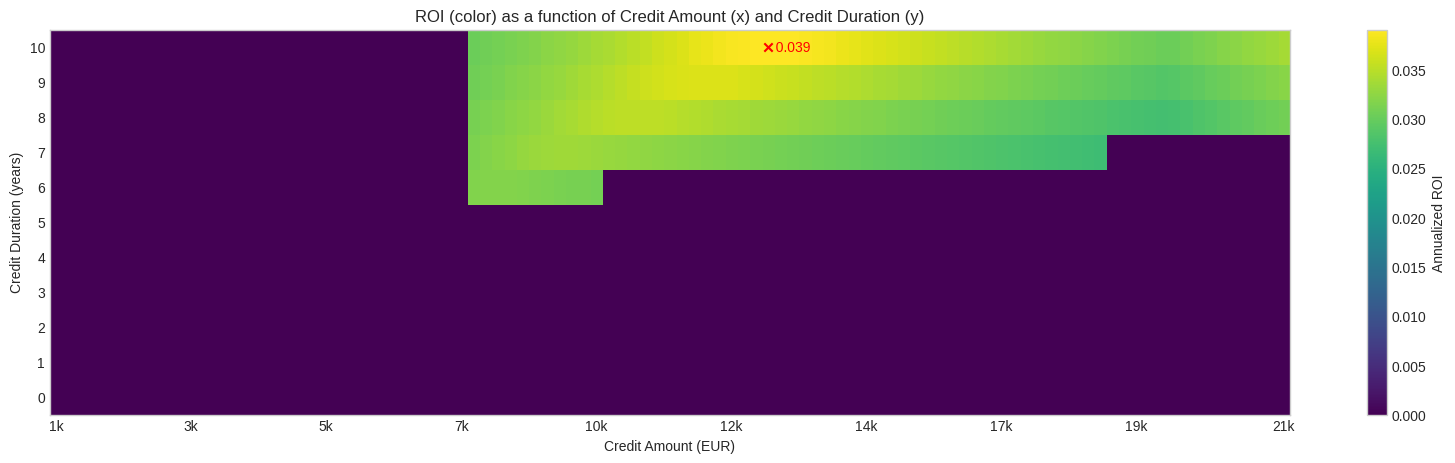

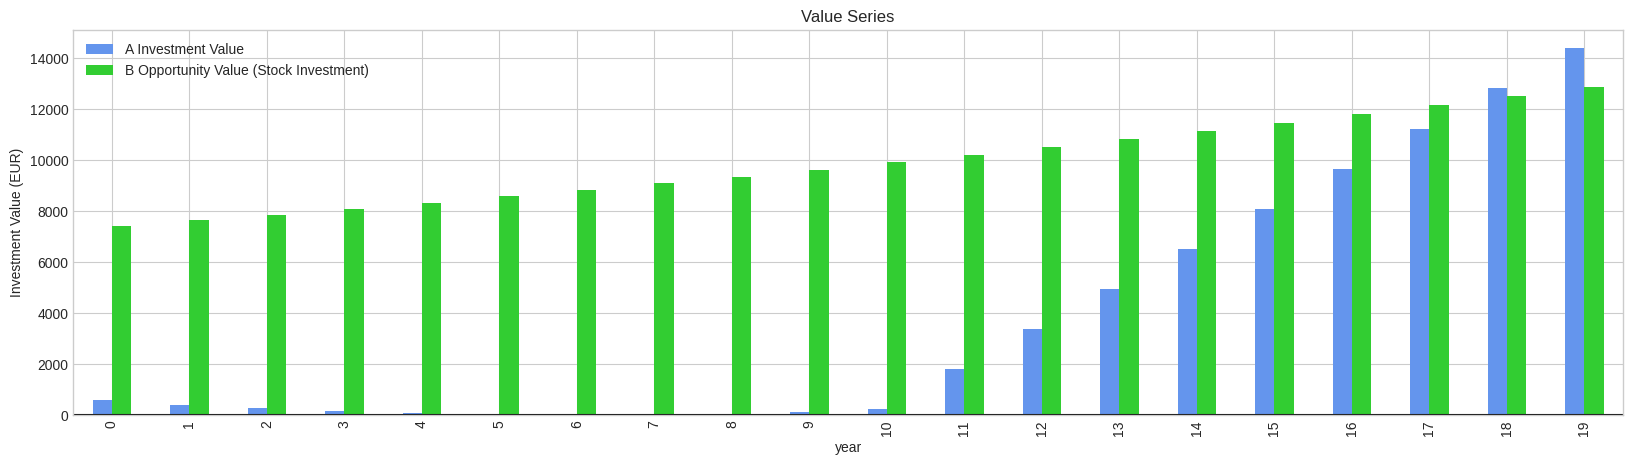

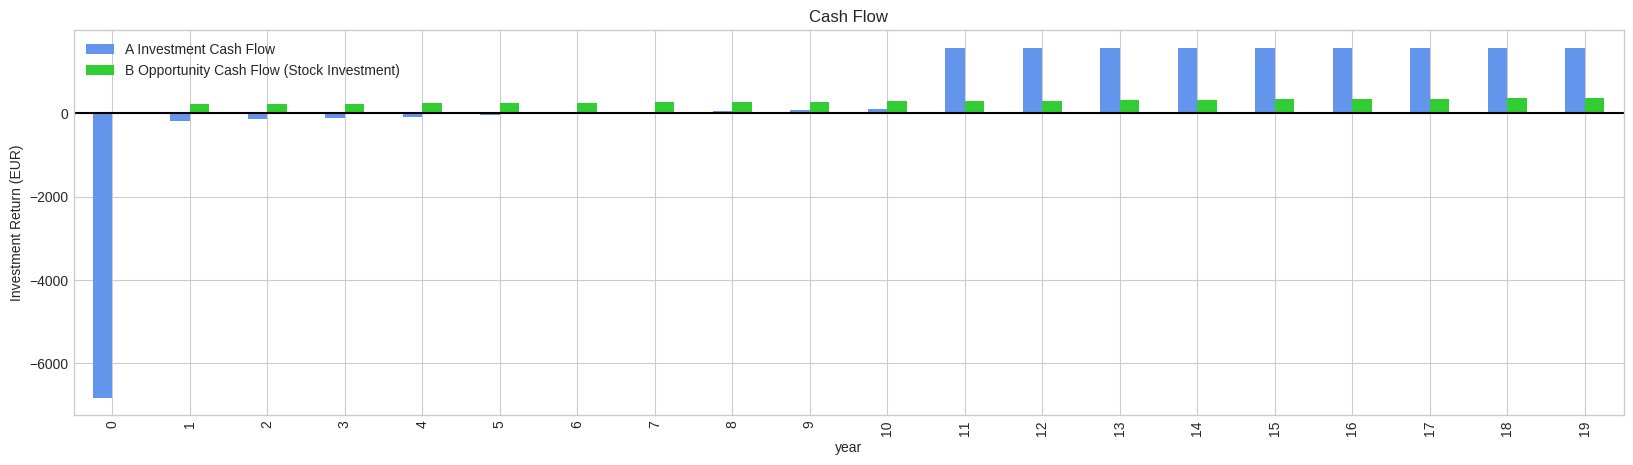

In [15]:
# Model & Presentation ...
# @CX-TOGGLE
#
# Model
#
INV_CF = CashFlow.from_investment(INV_LIFETIME, INV_COST, INV_ANNUAL_RETURN).discount(INV_INFLATION)
def _obj(ca, cd):
    credit = Credit(ca, cd, CREDIT_INTEREST)
    c_cf = credit.cash_flow().discount(EQ_INFLATION)
    cf = INV_CF + c_cf
    if cf.equity_need() > EQUITY_LIMIT:
        return 0
    return cf.aroi()
    
o = optimize_xy(_obj, CREDIT_AMOUNT_RANGE, CREDIT_DURATION_RANGE)

# A : Investment
credit = Credit(o.x_best, o.y_best, CREDIT_INTEREST)
A_CF = INV_CF + credit.cash_flow().discount(EQ_INFLATION)
equity = A_CF.equity_need()
years = max(INV_LIFETIME, credit.years)
A_EQ = ValueSeries.from_deposit(years, equity)
A_V  = A_EQ + ValueSeries.from_cash_flow(A_CF)

# B : Opportunity Costs
B_EQ = ValueSeries.from_deposit(years, equity)
B_CF = ValueSeries.from_deposit(INV_LIFETIME, equity).with_interest(EQ_INTEREST).discount(EQ_INFLATION).cash_flow(start_value=equity)
B_V  = B_EQ + ValueSeries.from_cash_flow(B_CF)

#
# Presentation
#
width = 20 
print(f"""# Investment Valuation

## Investment with Optimal Credit Leverage

total equity needed  : {equity:>{width},.0f} EUR
total returns        : {A_CF.pos().sum():>{width},.0f} EUR
return on investment : {A_CF.roi():>{width}.3f} x over {years} years
                       {A_CF.aroi() * 100:>{width}.3f} % p.a.

credit amount        : {credit.amount:>{width},.0f} EUR
credit duration      : {credit.years:>{width}} years
credit interest      : {CREDIT_INTEREST*100:>{width}.1f} % p.a. 
credit costs         : {credit.costs():>{width},.0f} EUR

## Opportunity Costs

equity invested      : {equity:>{width},.0f} EUR
total returns        : {B_V.total():>{width},.0f} EUR
return on investment : {B_V.roi():>{width}.3f} x over {years} years
                       {B_V.aroi() * 100:>{width}.3f} % p.a.
""")

im = plt.imshow(np.clip(o.VAL, 0, np.inf).T, origin='lower',  aspect='auto', cmap='viridis')
plt.colorbar(im, label='Annualized ROI')
plt.grid(False)

x_ticks_num = 10
x_ticks = np.linspace(0, o.x_len-1, x_ticks_num).astype(int)
x_tick_labels = [ f"{(o.x_lim[0] + (x/o.x_len) * (o.x_lim[1]-o.x_lim[0])) // 1000 :.0f}k" for x in x_ticks ]
plt.xticks(x_ticks, labels=x_tick_labels)
plt.xlabel("Credit Amount (EUR)")

plt.yticks(np.arange(o.y_len))
plt.ylabel("Credit Duration (years)")

plt.scatter(o.xi_best, o.yi_best, c='red', marker='x')
plt.text(o.xi_best, o.yi_best, f'  {o.o_best:.3f}', color='red', ha='left', va='center')
plt.grid(False)
plt.title("ROI (color) as a function of Credit Amount (x) and Credit Duration (y)")
plt.show();

# 
# Value Series
#
idx = pd.Series(np.arange(years),name="year")
pd.DataFrame({
  "A Investment Value" : A_V,
  "B Opportunity Value (Stock Investment)" : B_V,
}, index = idx).plot.bar(grid=True, color=["cornflowerblue", "limegreen"])
plt.axhline(y=0, color="black")
plt.title("Value Series")
plt.ylabel("Investment Value (EUR)")
plt.show()

#
# Cash Flow
#
pd.DataFrame({
  "A Investment Cash Flow": A_CF,
  "B Opportunity Cash Flow (Stock Investment)": B_CF
}, index = idx).plot.bar(grid=True, color=["cornflowerblue", "limegreen"])
plt.axhline(y=0, color="black")
plt.title("Cash Flow")
plt.ylabel("Investment Return (EUR)")
plt.show()

In [6]:
# @CX-NO-INPUT
H("""<script src="https://utteranc.es/client.js"
         repo="HeinrichHartmann/comments"
         issue-term="title"
         label="Comment"
         theme="github-light"
         crossorigin="anonymous"
         async>
</script>""")

In [16]:
# @CX-CUTOFF

In [17]:
# @CX-REMOVE
import ipynbname
nb_name = ipynbname.path().name

In [ ]:
%%script bash -s $nb_name
# @CX-REMOVE
#
# Export Notebook as Blogpost
#
./render.sh ./$1 ./nb.html
cat <<EOF > fm.html
---
title: Investment Calculator - Solar Plant
date: 2023-08-13
tags: inv, post
url: /ic
outputs:
  - RawHTML
---
EOF

cat fm.html nb.html \
    > /host/root/home/hhartmann/src/HeinrichHartmann.github.io/hugo/content/posts/raw/ic.html